In [1]:
import os
from collections.abc import MutableMapping
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from java_migration.eval.smol_log_parser import parse_log
from java_migration.eval.utils import recover_safe_repo_name
from java_migration.utils import REPO_ROOT


def flatten(dictionary, parent_key="", separator="_"):
    items = []
    for key, value in dictionary.items():
        new_key = parent_key + separator + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, separator=separator).items())
        else:
            items.append((new_key, value))
    return dict(items)

In [2]:
def get_experiment_data(experiment_path):
    exp_dirs = [Path(f.path) for f in os.scandir(experiment_path / "job_results") if f.is_dir()]
    repo_names = [recover_safe_repo_name(f.name) for f in exp_dirs]

    repo_dict = {repo_name: {} for repo_name in repo_names}

    repo_feats_path = REPO_ROOT / "data" / "repo_feats.yaml"
    with open(repo_feats_path) as fin:
        repo_feats = yaml.safe_load(fin.read())

    for exp_dir, repo_name in zip(exp_dirs, repo_names):
        if (exp_dir / "stdout.log").exists():
            repo_dict[repo_name]["agent_log"] = parse_log(open(exp_dir / "stdout.log").read())
        if (exp_dir / "result.yaml").exists():
            with open(exp_dir / "result.yaml") as fin:
                repo_dict[repo_name]["build_result"] = yaml.safe_load(fin.read())
        if repo_name in repo_feats:
            repo_dict[repo_name]["repo_feats"] = repo_feats[repo_name]

    return repo_dict


experiment_path = Path(
    "/Users/mayvic/Documents/git/java-migration-paper/data/experiments/2025-03-10/12-46-23-tender-noyce"
)
exp_data = get_experiment_data(experiment_path)

In [3]:
def get_experiment_features(exp_data):
    exp_feats = []
    for repo_name, repo_data in exp_data.items():
        cur_feats = {"repo_name": repo_name}
        if "build_result" in repo_data and repo_data["build_result"] is not None:
            cur_feats.update(flatten(repo_data["build_result"]))
        exp_feats.append(cur_feats)
        if "agent_log" in repo_data:
            cur_feats["run_duration"] = np.sum([y.meta.duration for y in repo_data["agent_log"].steps])
            cur_feats["input_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["output_tokens"] = np.sum([y.meta.input_tokens for y in repo_data["agent_log"].steps])
            cur_feats["num_steps"] = len(repo_data["agent_log"].steps)
        if "repo_feats" in repo_data:
            cur_feats.update(repo_data["repo_feats"])

    return exp_feats


exp_features = get_experiment_features(exp_data)
df = pd.DataFrame(exp_features)

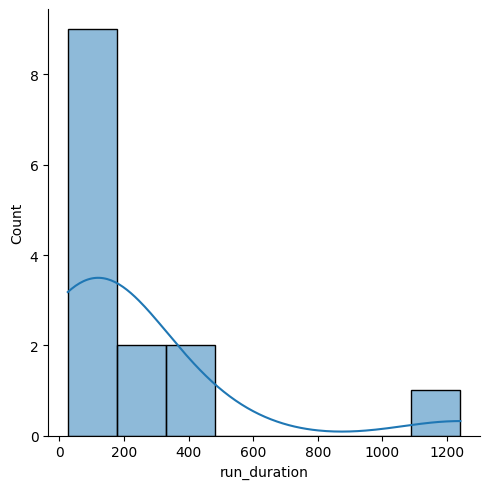

In [4]:
# df.run_duration.hist()

sns.displot(data=df["run_duration"], kde=True)

<Axes: xlabel='number_of_java_files', ylabel='num_steps'>

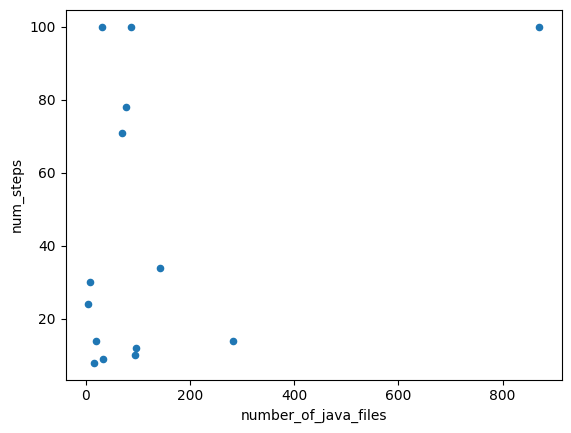

In [5]:
df.plot(x="number_of_java_files", y="num_steps", kind="scatter")

In [6]:
df

,repo_name,build_result_build_success,build_result_test_results_errors,build_result_test_results_failures,build_result_test_results_skipped,build_result_test_results_tests_run,build_result_test_success,error,run_success,run_duration,input_tokens,output_tokens,num_steps,build_tool,number_of_external_dependencies,number_of_java_files,number_of_lines_of_code,number_of_modules,number_of_unit_tests,build_result_test_results
0,DeemOpen/zkui,True,0.0,0.0,0.0,0.0,True,None,True,26.34,596460,596460,14,maven,28,20,2222,1,0,NaN
1,EalenXie/spring-microservice-ddd,True,0.0,0.0,0.0,2.0,True,None,True,36.75,183020,183020,9,maven,14,34,2053,1,1,NaN
2,killme2008/aviatorscript,True,26.0,0.0,0.0,1712.0,False,None,True,94.00,2404372,2404372,14,maven,12,283,47969,1,643,NaN
3,ata4/disunity,True,0.0,0.0,0.0,328.0,True,None,True,34.15,254645,254645,10,maven,12,95,7250,3,6,NaN
4,opengoofy/hippo4j,False,NaN,NaN,NaN,NaN,None,None,True,332.58,872607108,872607108,100,maven,48,870,69708,8,423,NaN
5,EnterpriseQualityCoding/FizzBuzzEnterpriseEdition,False,NaN,NaN,NaN,NaN,None,None,True,471.19,440513968,440513968,100,maven,12,87,2489,1,1,NaN
6,alibaba/QLExpress,True,NaN,NaN,NaN,NaN,True,None,True,173.27,20001627,20001627,34,maven,10,142,10938,1,193,NaN
7,SPuerBRead/Bridge,True,NaN,NaN,NaN,NaN,True,None,True,1241.15,457174261,457174261,100,maven,16,32,2408,1,0,NaN
8,joelittlejohn/jsonschema2pojo,True,0.0,0.0,0.0,1214.0,True,None,True,112.20,1887625,1887625,12,maven,101,96,15097,6,671,NaN
9,Netflix/Surus,True,0.0,0.0,0.0,20.0,True,None,True,141.38,9531206,9531206,24,maven,8,5,1027,1,10,NaN


In [12]:
df[(not df.build_result_test_success) | (not df.build_result_build_success)].repo_name.tolist()


# ['EnterpriseQualityCoding/FizzBuzzEnterpriseEdition',
#  'alibaba/QLExpress',
#  'joelittlejohn/jsonschema2pojo',
#  'Netflix/Surus',
#  'nydiarra/springboot-jwt',
#  'Codecademy/EventHub']

['killme2008/aviatorscript',
 'opengoofy/hippo4j',
 'EnterpriseQualityCoding/FizzBuzzEnterpriseEdition',
 'Ouyangan/hunt-admin',
 'anjia0532/unidbg-boot-server',
 'Codecademy/EventHub']

In [15]:
df[
    [
        "build_result_build_success",
        "build_result_test_success",
        "number_of_unit_tests",
        "number_of_modules",
        "number_of_lines_of_code",
        "number_of_java_files",
        "num_steps",
        "input_tokens",
        "output_tokens",
    ]
].corr()

,build_result_build_success,build_result_test_success,number_of_unit_tests,number_of_modules,number_of_lines_of_code,number_of_java_files,num_steps,input_tokens,output_tokens
build_result_build_success,1.000000,NaN,0.135441,-0.376163,-0.186545,-0.314453,-0.669975,-0.501590,-0.501590
build_result_test_success,NaN,1.000000,-0.626544,0.169975,-0.943501,-0.854567,0.140580,0.129803,0.129803
number_of_unit_tests,0.135441,-0.626544,1.000000,0.484452,0.724187,0.530895,-0.126124,0.100181,0.100181
number_of_modules,-0.376163,0.169975,0.484452,1.000000,0.595911,0.652845,0.320288,0.547443,0.547443
number_of_lines_of_code,-0.186545,-0.943501,0.724187,0.595911,1.000000,0.938479,0.234352,0.556396,0.556396
number_of_java_files,-0.314453,-0.854567,0.530895,0.652845,0.938479,1.000000,0.387194,0.717139,0.717139
num_steps,-0.669975,0.140580,-0.126124,0.320288,0.234352,0.387194,1.000000,0.840889,0.840889
input_tokens,-0.501590,0.129803,0.100181,0.547443,0.556396,0.717139,0.840889,1.000000,1.000000
output_tokens,-0.501590,0.129803,0.100181,0.547443,0.556396,0.717139,0.840889,1.000000,1.000000


In [13]:
set(
    [
        "killme2008/aviatorscript",
        "opengoofy/hippo4j",
        "EnterpriseQualityCoding/FizzBuzzEnterpriseEdition",
        "Ouyangan/hunt-admin",
        "anjia0532/unidbg-boot-server",
        "Codecademy/EventHub",
    ]
) & set(
    [
        "EnterpriseQualityCoding/FizzBuzzEnterpriseEdition",
        "alibaba/QLExpress",
        "joelittlejohn/jsonschema2pojo",
        "Netflix/Surus",
        "nydiarra/springboot-jwt",
        "Codecademy/EventHub",
    ]
)

{'Codecademy/EventHub', 'EnterpriseQualityCoding/FizzBuzzEnterpriseEdition'}

In [19]:
df.groupby("build_result_build_success")[
    [
        "number_of_unit_tests",
        "number_of_modules",
        "number_of_lines_of_code",
        "number_of_java_files",
        "num_steps",
        "input_tokens",
        "output_tokens",
    ]
].median()

,number_of_unit_tests,number_of_modules,number_of_lines_of_code,number_of_java_files,num_steps,input_tokens,output_tokens
build_result_build_success,,,,,,,
False,21.0,2.0,4589.0,77.0,78.0,300589645.0,300589645.0
True,6.0,1.0,2408.0,34.0,14.0,1887625.0,1887625.0


<Axes: xlabel='build_result_build_success', ylabel='number_of_lines_of_code'>

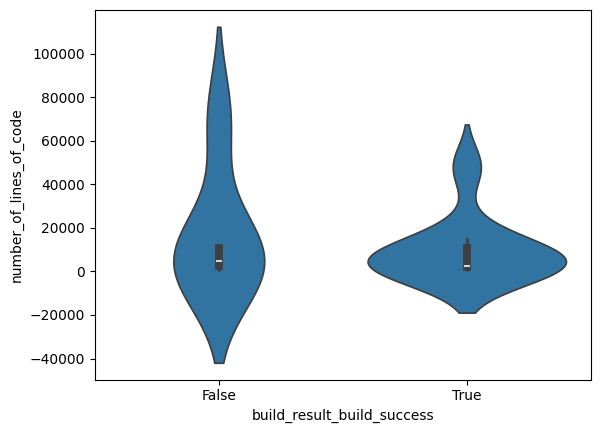

In [26]:
sns.violinplot(x="build_result_build_success", y="number_of_lines_of_code", data=df)